In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms

import yaml
import random
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
timesteps = 100
dt = 1e-3
tau_syn = 5e-3
tau_mem = 20e-3

neuron_params = {
        "threshold": 1.0,
        "i_offset": 0.0,
        "reset": "reset_to_v_reset",
        "dt": dt,
        "tau_mem": tau_mem,
        "tau_syn": tau_syn,
    }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
dims = [1, 2]
gains = np.array([0.4, 2]) * 1e1
np.random.seed(43)

In [5]:
spike_times = np.linspace(10, timesteps, 4, endpoint=False, dtype=int)[None, :]
input_spikes = np.zeros((timesteps, 1, dims[0]))
for n, times in enumerate(spike_times) : 
    input_spikes[times, 0, n] = 1

input_spikes = torch.from_numpy(input_spikes).float().to(device)

In [6]:
from eventprop.models import SNN

In [7]:
model_config = {
    "T": timesteps,
    "dt": dt,
    "tau_m": tau_mem,
    "tau_s": tau_syn,
    "mu": 1.,
    "resolve_silent": False,
    "device": device,
    "get_first_spikes": False,
    "model_type" : "eventprop"
}


In [8]:
eventprop_model = SNN(dims, **model_config).to(device)
layer = eventprop_model.layers[0]

In [9]:
layer.weight.data = torch.arange(1, dims[0] * dims[1] + 1).reshape(dims[1], dims[0]) * gains[0]

In [10]:
pack, _ = layer.manual_forward(input_spikes)
(input, V, I, out_spikes) = pack

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [11]:
spike_times = torch.where(out_spikes[:, 0])
spike_times = {
    n : spike_times[0][spike_times[1] == n].cpu().data.numpy() for n in range(dims[1])
}
spike_times
first_spike_times = {
    n : spike_times[n][0] if len(spike_times[n]) > 0 else -1 for n in range(dims[1])
}
first_spikes_only = torch.zeros_like(out_spikes)
for n in range(dims[1]) : 
    if first_spike_times[n] > 0 : 
        first_spikes_only[first_spike_times[n], 0, n] = 1

NameError: name 'out_spikes' is not defined

In [12]:
spike_times

{0: array([61]), 1: array([15, 35, 58, 80])}

In [13]:
LOSS_ALPHA = 3e-3
LOSS_TAU_0 = 5e-4
LOSS_TAU_0_INV = 1. / LOSS_TAU_0
LOSS_TAU_1 = 6.4e-3
LOSS_DT = 1e-3
LOSS_DT_TAU_0_RATIO = LOSS_DT / LOSS_TAU_0
LOSS_DT_TAU_1_RATIO = LOSS_DT / LOSS_TAU_1
LOSS_ALPHA_TAU_1_RATIO = LOSS_ALPHA / LOSS_TAU_1

In [14]:
labels = 0
first_spike_errors = {
    n : 0 for n in range(dims[1])
}
t_l = first_spike_times[labels]
sum0 = 0
for n in range(dims[1]) : 
    if first_spike_times[n] != -1 : 
        sum0 += np.exp(-(first_spike_times[n] ) * LOSS_DT_TAU_0_RATIO)
    
label_error = LOSS_TAU_0_INV * (1 - np.exp(-t_l * LOSS_DT_TAU_0_RATIO) / sum0) + LOSS_ALPHA_TAU_1_RATIO * np.exp(t_l * LOSS_DT_TAU_1_RATIO)
first_spike_errors[labels] += label_error
for n in range(dims[1]) : 
    if first_spike_times[n] != -1 and labels != n: 
        first_spike_errors[n] = -LOSS_TAU_0_INV * (1 / sum0) * np.exp(-(first_spike_times[n]) * LOSS_DT_TAU_0_RATIO) 

In [15]:
first_spike_grads = torch.cat(list({
    n : spikes * error for spikes, (n, error) in zip(first_spikes_only.split(1, dim=-1), first_spike_errors.items())
}.values()), -1)

In [16]:
grad_input, grad_weight, lV, lI = layer.manual_backward(-first_spike_grads, pack)

{'jump': tensor([[12633.6807,     0.0000]]), 'grad_output': tensor([[-8461.1611,     0.0000]]), 'V_dot': tensor([[0.6697, 2.8456]]), 'lV[i+1]': tensor([[0., 0.]]), 'lI[i+1]': tensor([[0., 0.]]), 'I[i]': tensor([[1.6481, 3.2963]]), 'I[i-1]': tensor([[2.0602, 4.1204]]), 'V[i]': tensor([[0.9784, 0.4507]]), 'V[i-1]': tensor([[0.9215, 0.2575]])}
{'jump': tensor([[   0.0000, -629.9212]]), 'grad_output': tensor([[  -0., 2000.]]), 'V_dot': tensor([[1.5875, 3.1750]]), 'lV[i+1]': tensor([[1256.2958,    0.0000]]), 'lI[i+1]': tensor([[1674.3279,    0.0000]]), 'I[i]': tensor([[2.0480, 4.0960]]), 'I[i-1]': tensor([[2.5600, 5.1200]]), 'V[i]': tensor([[0.4605, 0.9210]]), 'V[i-1]': tensor([[0.3500, 0.7000]])}


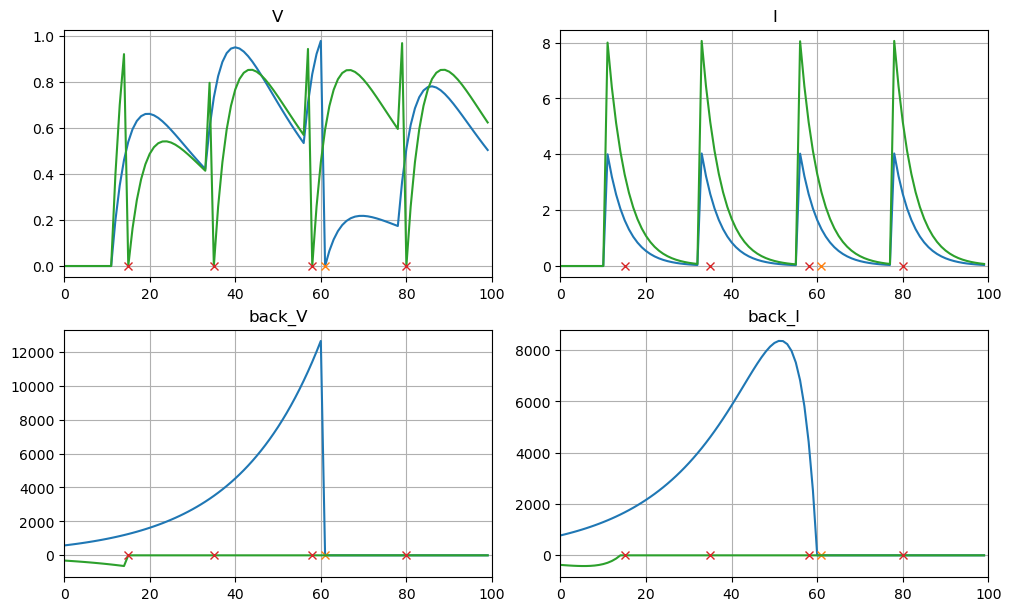

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)
for ax, data, title in zip(axs.T.flatten(), [V, lV, I, lI], ["V", "back_V", "I", "back_I"]) : 
    for n in range(dims[1]) : 
        ax.plot(data[:, 0, n].cpu().data.numpy(), label=f"neuron {n}")
        ax.plot(spike_times[n], np.zeros_like(spike_times[n]), "x", label=f"spike {n}")
    ax.set_title(title)
    ax.grid(visible=True)
    ax.set_xlim(0, timesteps)

In [18]:
(I != 0)[:, 0, 0].int().argmax()

tensor(11)

In [19]:
spike_times

{0: array([61]), 1: array([15, 35, 58, 80])}

In [20]:
{n : I[spike_times[n]  , 0, n].cpu().data.numpy() for n in range(dims[1])}

{0: array([1.3185142], dtype=float32),
 1: array([3.2768002, 5.157779 , 5.1504464, 5.158004 ], dtype=float32)}

In [21]:
{n : V[spike_times[n] - 1, 0, n].cpu().data.numpy() for n in range(dims[1])}

{0: array([0.97841233], dtype=float32),
 1: array([0.921     , 0.7964295 , 0.94355226, 0.96884656], dtype=float32)}

In [22]:
spike_times

{0: array([61]), 1: array([15, 35, 58, 80])}

In [23]:
torch.roll(input_spikes, 1, 0).argmax()

tensor(11)

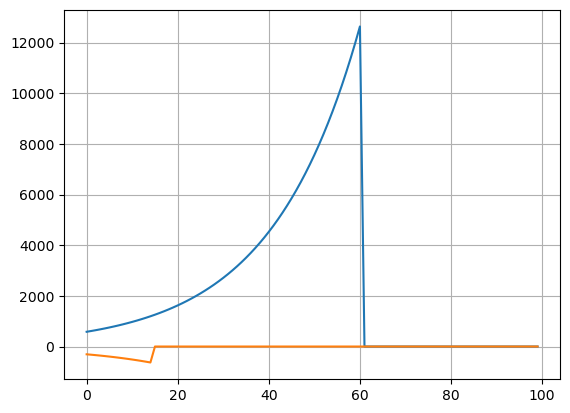

In [24]:
plt.plot(lV[:, 0].cpu().data.numpy())
plt.grid(visible=True)

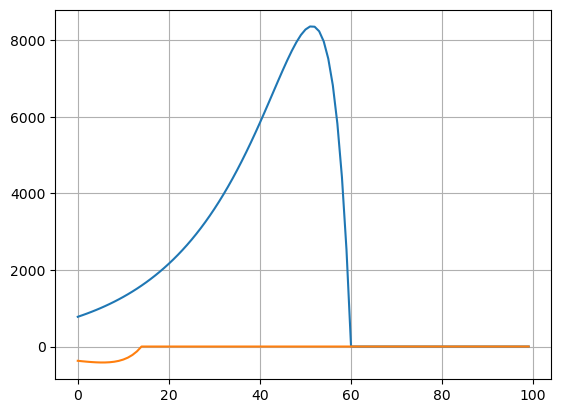

In [25]:
plt.plot(lI[:, 0].cpu().data.numpy())
plt.grid(visible=True)